In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from Dataset import *
from torchvision import transforms
from p_tqdm import p_umap
from functools import partial


In [15]:
frame_width,frame_height = 250,150
x,y = 450,780
pt1_L = (x, y)
pt2_L = (450+frame_width, 780+frame_height)
x,y = 1450,800
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)

In [2]:
# Load Excel file
def load_excel_data(file_path):
    activation_df = pd.read_excel(file_path, sheet_name="Activation")
    non_activation_df = pd.read_excel(file_path, sheet_name="NonActivation")
    return activation_df, non_activation_df


In [7]:
# Process the dataset
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
excel_file_path = r"D:\LiDAR_Data\2ndPHB\Video\Activation.xlsx"
output_dir = r"D:\LiDAR_Data\2ndPHB\Video\Dataset"
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
time_window = 3 # seconds
# Load the Excel data
activation_df, non_activation_df = load_excel_data(excel_file_path)
excel_file_1 = r"D:\LiDAR_Data\2ndPHB\Video\HAWK Pedestrian Behavior.xlsx"
student_file = pd.read_excel(excel_file_1)

In [8]:
"""
Conbine the my labels and high school student labels
"""
student_activation_L = student_file.loc[(student_file.Bound == 'N') & (student_file.loc[:,'Pressed?'] == 'Y')].copy()
student_activation_R = student_file.loc[(student_file.Bound == 'S') & (student_file.loc[:,'Pressed?'] == 'Y')].copy()
# uniform the column names and data format
# combine Date column and Time column in student_activation_L and student_activation_R, and convert to YYYYMMDD_HHMMSS format
timestamp = student_activation_L['Date'].astype(str) + '_' + student_activation_L['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
# eliminate '-' in the timestamp
timestamp = timestamp.str.replace('-','')
student_activation_L.loc[:,'timestamp'] = timestamp
timestamp = student_activation_R['Date'].astype(str) + '_' + student_activation_R['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
timestamp = timestamp.str.replace('-','')
student_activation_R.loc[:,'timestamp'] = timestamp
# combine student_activation_L and student_activation_R to activation_df
student_activation_L.loc[:, 'location'] = 'L'
student_activation_R.loc[:, 'location'] = 'R'
student_activation_L = student_activation_L.loc[:,['timestamp','location']]
student_activation_R = student_activation_R.loc[:,['timestamp','location']]
student_activation = pd.concat([student_activation_L, student_activation_R], axis=0)
activation_df = pd.concat([activation_df, student_activation], axis=0)
# filter duplicate rows
activation_df.drop_duplicates(inplace=True)

In [9]:
""" identify unvisited video files"""
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
total_video_list = os.listdir(video_dir)
# video file format: 00_00_192.168.1.108_1_20241204_224500.avi
# activation record format: 20241204_224500
# identify the video files that are not in the excel file
total_record_list = activation_df["timestamp"].tolist() + non_activation_df["timestamp"].tolist()
# convert to timestamp
total_record_list = [datetime.strptime(record, "%Y%m%d_%H%M%S") for record in total_record_list]
total_record_list_ = []
for record in total_record_list:
    record = record - timedelta(minutes = record.minute % 5)
    record = record.replace(second = 0 )
    total_record_list_.append(record)
unique_record_list = list(set(total_record_list_))
unvisited_video_list = []
for video in total_video_list:
    video_start_timestamp = video[22:].split(".")[0]
    video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
    if video_start_timestamp not in unique_record_list:
        unvisited_video_list.append(video)
save_path = r'D:\LiDAR_Data\2ndPHB\Video\round2\unvisited_video_list.csv'
df = pd.DataFrame(unvisited_video_list)
df.to_csv(save_path, index = False)

450 780 250 150


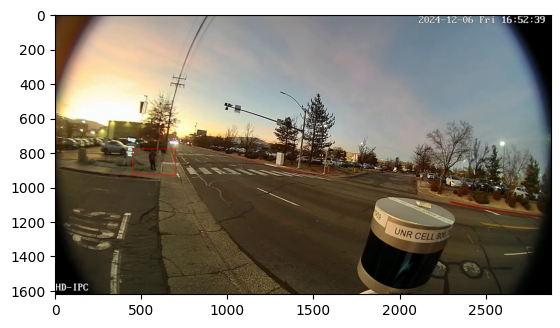

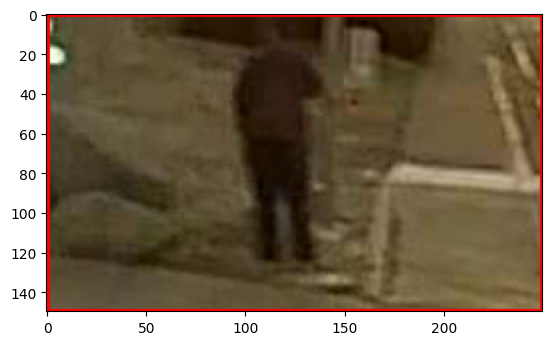

In [10]:
""" Select ROI for the video clips"""
video_path = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train\1_20241206_165239_L.mp4'
cap = cv2.VideoCapture(video_path)
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
cap.release()
frames = np.array(frames) # (seq_len, h, w, c)
test_img = frames[30].copy()
w,h = 250,150
x,y = 450,780
pt1_L = (x, y)
pt2_L = (450+w, 780+h)
print(x,y,w,h)
cv2.rectangle(test_img, pt1_L, pt2_L, (255, 0, 0), 2)
plt.imshow(test_img)
# draw a rectangle around the object
plt.show()
# crop the image
cropped_img = test_img[y:y+h, x:x+w]
plt.imshow(cropped_img)
plt.show()

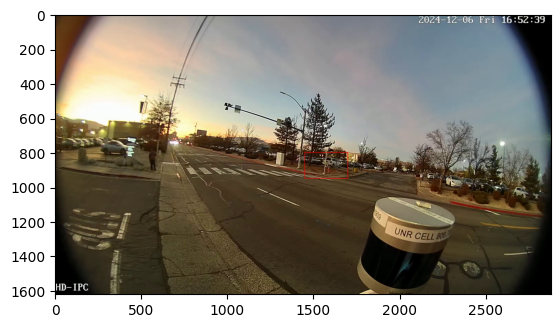

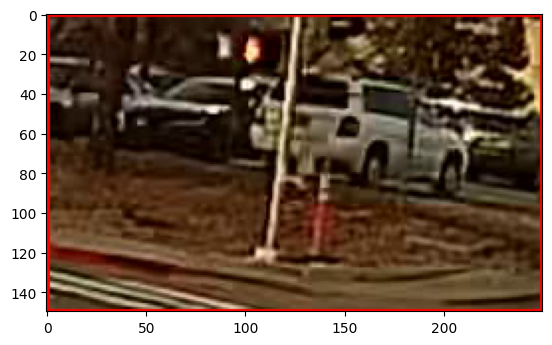

In [11]:
x,y = 1450,800
pt1_R = (x, y)
pt2_R = (x+w, y+h)
test_img = frames[30].copy()
cv2.rectangle(test_img, pt1_R, pt2_R, (255, 0, 0), 2)
plt.imshow(test_img)
# draw a rectangle around the object
plt.show()
# crop the image
cropped_img = test_img[y:y+h, x:x+w]
plt.imshow(cropped_img)
plt.show()

In [12]:
time_window = 3 # seconds (30 frames)
fps = 10
# Prepare data for activation and non-activation
date_times = []
start_frames = []
end_frames = []
save_names = []
for df, label in [(activation_df, 1), (non_activation_df, 0)]:
    for _, row in tqdm(df.iterrows()):
        record_timestamp = row["timestamp"]
        location = row["location"]
        # convert to datetime object
        record_timestamp = datetime.strptime(record_timestamp, "%Y%m%d_%H%M%S")
        
        # Match the video file with the timestamp
        for video_file in os.listdir(video_dir):
            video_start_timestamp = video_file[22:].split(".")[0]
            # convert to datetime object
            video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
            video_end_timestamp = video_start_timestamp + timedelta(seconds=60 * 5)
            if video_start_timestamp <= record_timestamp <= video_end_timestamp:
                # convert video_start_timestamp to '%Y-%m-%d-%H-%M-%S'
                video_start_timestamp_str = video_start_timestamp.strftime('%Y-%m-%d-%H-%M-%S')
                # window screening for the video clips making sure the record_timestamp is each 30 seconds
                screen_start_frame = int((record_timestamp - video_start_timestamp).seconds * fps)
                screen_end_frame = screen_start_frame + time_window * fps
                for step in range(2,18): # 2 frame margin for consevative screening
                    start_frame = int(screen_start_frame + step)
                    end_frame = int(screen_end_frame + step)
                    start_frames.append(start_frame)
                    end_frames.append(end_frame)
                    date_times.append(video_start_timestamp_str)
                    save_names.append(f"{label}_{video_start_timestamp_str}_{start_frame}_{location}.mp4")

288it [00:02, 133.69it/s]
405it [00:03, 131.95it/s]


In [28]:
# make the dataframe
# data = {"date_time": date_times, "start_frame": start_frames, "end_frame": end_frames, "save_name": save_names}
# df = pd.DataFrame(data)
# video file format: 00_00_192.168.1.108_1_20241204_224500.avi
target_video_paths = []
target_frames = []
save_names = []
locations = []
for date_time,g in df.groupby("date_time"):
    # convert date_time to YYYYMMDD_HHMMSS
    date_time = datetime.strptime(date_time, "%Y-%m-%d-%H-%M-%S").strftime("%Y%m%d_%H%M%S")
    video_file = f"00_00_192.168.1.108_1_{date_time}.avi"
    video_path = os.path.join(video_dir, video_file)
    target_video_paths.append(video_path)
    target_start_frames = g["start_frame"].tolist()
    target_end_frames = g["end_frame"].tolist()
    target_frames.append(np.c_[target_start_frames, target_end_frames])
    save_names.append(g["save_name"].tolist())
    locations.append(g["save_name"].str[-5].tolist())
    # break


In [39]:
frame_width,frame_height = 250,150
x,y = 450,780
pt1_L = (x, y)
pt2_L = (450+frame_width, 780+frame_height)
x,y = 1450,800
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
ROI_L, ROI_R = [pt1_L, pt2_L], [pt1_R, pt2_R]
def write_video(output_path, frames, fourcc, fps, frame_width, frame_height,location):
    """
    Writes a video file using OpenCV.

    Args:
        output_path (str): Path to save the video.
        frames (list): List of frames to write.
        fourcc (int): Codec.
        fps (int): Frames per second.
        frame_width (int): Width of the frame.
        frame_height (int): Height of the frame.
    """
    # Set up VideoWriter for saving the output
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    for frame in frames:
        if location == 'L':
            # crop the image to the ROI
            frame = frame[ROI_L[0][1]:ROI_L[1][1], ROI_L[0][0]:ROI_L[1][0]]
        elif location == 'R':
            frame = frame[ROI_R[0][1]:ROI_R[1][1], ROI_R[0][0]:ROI_R[1][0]]
        out.write(frame)
    # Release resources
    out.release()

def clip_single_video(input_video_path, save_names, target_frames, locations, output_folder):
    """
    Clips a video using OpenCV based on start and end timestamps.

    Args:
        input_path (str): Path to the input video file.
        output_path (str): Path to save the clipped video.
        start_time (float): Start time in seconds.
        end_time (float): End time in seconds.
    """
    # Open the video file
    cap = cv2.VideoCapture(input_video_path)
    
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec

    init_frame = target_frames[:,0].min()
    ending_frame = target_frames[:,1].max()
    current_frame = init_frame
    # Set the starting position of the video
    cap.set(cv2.CAP_PROP_POS_FRAMES, init_frame)

    frames = []
    frame_inds = []
    while current_frame <= ending_frame:
        ret, frame = cap.read()
        if not ret:
            # print("End of video reached or error reading frame.")
            break
        frames.append(frame)
        frame_inds.append(current_frame)
        current_frame += 1
    for i in range(len(target_frames)):
        start_frame = target_frames[i,0]
        end_frame = target_frames[i,1]
        start_ind = np.where(frame_inds == start_frame)[0][0]
        end_ind = np.where(frame_inds == end_frame)[0][0]
        save_name = save_names[i]
        location = locations[i]
        output_path = os.path.join(output_folder, save_name)
        write_video(output_path, frames[start_ind:end_ind], fourcc, fps, frame_width, frame_height,location)
    # Release resources
    cap.release()

In [ ]:
n_cpu = 4
output_folder = clip_save_dir
p_umap(
        partial(clip_single_video, output_folder=output_folder, cv2=cv2),
        target_video_paths,
        save_names,
        target_frames,
        locations,
        num_cpus = n_cpu
    )

In [15]:
# Split the dataset into train, validation with 80% and 20% respectively
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
clips = os.listdir(clip_save_dir)
train_clips, val_clips = train_test_split(clips, test_size=0.2, random_state=714)
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\R_signal\train'
val_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\R_signal\val'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
# Move the clips to the respective folders
for clip in train_clips:
    # if the clip is right signal
    if clip.split('_')[-1][0] == 'R':
        src = os.path.join(clip_save_dir, clip)
        dst = os.path.join(train_folder, clip)
        os.rename(src, dst)
for clip in val_clips:
    # if the clip is right signal
    if clip.split('_')[-1][0] == 'R':
        src = os.path.join(clip_save_dir, clip)
        dst = os.path.join(val_folder, clip)
        os.rename(src, dst)
# Split the dataset into train, validation with 80% and 20% respectively
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
clips = os.listdir(clip_save_dir)
train_clips, val_clips = train_test_split(clips, test_size=0.2, random_state=714)
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train'
val_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
# Move the clips to the respective folders
for clip in train_clips:
    # if the clip is right signal
    if clip.split('_')[-1][0] == 'L':
        src = os.path.join(clip_save_dir, clip)
        dst = os.path.join(train_folder, clip)
        os.rename(src, dst)
for clip in val_clips:
    # if the clip is right signal
    if clip.split('_')[-1][0] == 'L':
        src = os.path.join(clip_save_dir, clip)
        dst = os.path.join(val_folder, clip)
        os.rename(src, dst)

In [56]:

# empty video list
empty_video_list = np.array(pd.read_excel(r'D:\LiDAR_Data\2ndPHB\Video\EmptyVideo.xlsx',header=None))
empty_video_list = np.array(empty_video_list).flatten()
out_folder_left = r'D:\LiDAR_Data\2ndPHB\Video\NewSampledClips_0\Left_signal'
out_folder_right = r'D:\LiDAR_Data\2ndPHB\Video\NewSampledClips_0\Right_signal'
if not os.path.exists(out_folder_left):
    os.makedirs(out_folder_left)
if not os.path.exists(out_folder_right):
    os.makedirs(out_folder_right)
video_folder = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo'
# clip all videos in empty_video_list into 3 seconds clips and save to out_folder
for i in range(len(empty_video_list)):
    print(f"Processing {i+1}/{len(empty_video_list)}")
    video_file = empty_video_list[i] + '.avi'
    video_path = os.path.join(video_folder, video_file)
    # out format: 0_2024-12-04-18-30-00_592_L.mp4
    date_str = empty_video_list[0][-15:]
    # convert date_str from YYYYMMDD_HHMMSS to YYYY-MM-DD-HH-MM-SS
    date = datetime.strptime(date_str, "%Y%m%d_%H%M%S").strftime("%Y-%m-%d-%H-%M-%S")
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        continue
    L_frames = []
    R_frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        L_frame = frame[pt1_L[1]:pt2_L[1], pt1_L[0]:pt2_L[0]]
        R_frame = frame[pt1_R[1]:pt2_R[1], pt1_R[0]:pt2_R[0]]
        L_frames.append(L_frame)
        R_frames.append(R_frame)
    cap.release()
    # for each direction, sample 500 clips
    sampled_frames = np.random.choice(len(L_frames), 500, replace=False)
    for j in tqdm(sampled_frames):
        start_frame = j
        end_frame = j + fps*3
        if end_frame > len(L_frames):
            continue
        if start_frame < 0:
            continue
        L_clip = L_frames[start_frame:end_frame]
        R_clip = R_frames[start_frame:end_frame]
        save_name = f"0_{date}_{start_frame}_L.mp4"
        out_path = os.path.join(out_folder_left, save_name)
        out = cv2.VideoWriter(out_path, fourcc, fps, (frame_width, frame_height))
        for frame in L_clip:
            out.write(frame)
        out.release()
        save_name = f"0_{date}_{start_frame}_R.mp4"
        out_path = os.path.join(out_folder_right, save_name)
        out = cv2.VideoWriter(out_path, fourcc, fps, (frame_width, frame_height))
        for frame in R_clip:
            out.write(frame)
        out.release()


        
    
    


Processing 1/13


100%|██████████| 500/500 [00:19<00:00, 26.29it/s]


Processing 2/13


100%|██████████| 500/500 [00:23<00:00, 21.30it/s]


Processing 3/13


100%|██████████| 500/500 [00:31<00:00, 15.80it/s]


Processing 4/13


100%|██████████| 500/500 [00:21<00:00, 23.75it/s]


Processing 5/13


100%|██████████| 500/500 [00:20<00:00, 23.91it/s]


Processing 6/13


100%|██████████| 500/500 [00:19<00:00, 26.19it/s]


Processing 7/13


100%|██████████| 500/500 [00:18<00:00, 26.92it/s]


Processing 8/13


100%|██████████| 500/500 [00:21<00:00, 22.94it/s]


Processing 9/13


100%|██████████| 500/500 [00:20<00:00, 24.50it/s]


Processing 10/13


100%|██████████| 500/500 [00:30<00:00, 16.41it/s]


Processing 11/13


100%|██████████| 500/500 [00:37<00:00, 13.34it/s]


Processing 12/13


100%|██████████| 500/500 [00:24<00:00, 20.06it/s]


Processing 13/13


100%|██████████| 500/500 [00:23<00:00, 21.02it/s]


In [60]:
sample_clip_folder_left = r'D:\LiDAR_Data\2ndPHB\Video\NewSampledClips_0\Left_signal'
sample_clip_folder_right = r'D:\LiDAR_Data\2ndPHB\Video\NewSampledClips_0\Right_signal'
sample_clips_left = os.listdir(sample_clip_folder_left)
sample_clips_right = os.listdir(sample_clip_folder_right)
# count the number of clips in the train and val folders
train_clips = os.listdir(train_folder)
val_clips = os.listdir(val_folder)
# count 0 and 1 in the train and val folders
train_labels = [int(clip.split('_')[0]) for clip in train_clips]
val_labels = [int(clip.split('_')[0]) for clip in val_clips]
num_train = len(train_labels)
num_val = len(val_labels)
train_0 = train_labels.count(0) 
train_1 = train_labels.count(1)
val_0 = val_labels.count(0)
val_1 = val_labels.count(1)
# random sample 0 clips for val and train, such that the ratio of 0 and 1 will no greater than 2:1
# sample 0 clips for train
sample_0_train = int(np.ceil(train_1 * 2))
num_required_0_train = sample_0_train - train_0
# sample 0 clips for val
sample_0_val = int(np.ceil(val_1 * 2))
num_required_0_val = sample_0_val - val_0

sampled_clips_left_train = np.random.choice(sample_clips_left, num_required_0_train, replace=False)
sampled_clips_left_val = np.random.choice(sample_clips_left, num_required_0_val, replace=False)
sampled_clips_right_train = np.random.choice(sample_clips_right, num_required_0_train, replace=False)
sampled_clips_right_val = np.random.choice(sample_clips_right, num_required_0_val, replace=False)



In [ ]:
import shutil
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train'
val_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
# copy the sampled clips to the train folder
for clip in sampled_clips_left_train:
    src = os.path.join(sample_clip_folder_left, clip)
    dst = os.path.join(train_folder, clip)
    shutil.copy(src, dst)
for clip in sampled_clips_left_val:
    src = os.path.join(sample_clip_folder_left, clip)
    dst = os.path.join(val_folder, clip)
    shutil.copy(src, dst)

In [64]:
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\R_signal\train'
val_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\R_signal\val'
# copy the sampled clips to the train folder
for clip in sampled_clips_right_train:
    src = os.path.join(sample_clip_folder_right, clip)
    dst = os.path.join(train_folder, clip)
    shutil.copy(src, dst)
for clip in sampled_clips_right_val:
    src = os.path.join(sample_clip_folder_right, clip)
    dst = os.path.join(val_folder, clip)
    shutil.copy(src, dst)

In [1]:
from Dataset import VideoDataset
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from Loss import FocalLoss
from torchvision import models
import albumentations as A
from Model import CNNLSTMAttention
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [2]:
# Custom Transform for Normalization
def preprocessing(frames):
    """ Normalize frames (batch_size, seq_len, h, w, c) """
    # to tensor
    frames = torch.tensor(frames)
    frames = frames / 255.0  # Scale pixel values to [0, 1]
    mean = torch.tensor([0.485, 0.456, 0.406])  # Imagenet mean for RGB
    std = torch.tensor([0.229, 0.224, 0.225])  # Imagenet std for RGB
    frames = (frames - mean) / std  # Normalize
    frames = frames.to(torch.float32).permute(0,3,1,2)
    # frames = torch.nn.functional.interpolate(frames.permute(0,3,1,2), size=224, mode = 'bilinear', align_corners=False)
    return frames

transform_aug = A.Compose([
    A.Illumination(p=0.5),
    A.Equalize(p=0.5),
    A.RandomSunFlare(p=0.3,flare_roi=(0,0,1,0.5)),
    A.ElasticTransform(p=0.2,alpha=1,sigma=50),
])

def create_data_loaders(train_dir, val_dir, batch_size=4, preprocess=None, augmentation=None):
    train_dataset = VideoDataset(train_dir, preprocess=preprocess, augmentation=augmentation)
    val_dataset = VideoDataset(val_dir, preprocess=preprocess)
    # test_dataset = VideoDataset(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
train_loader, val_loader = create_data_loaders(train_dir, val_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)

In [3]:
for i, (frames, label, location) in enumerate(train_loader):
    break

In [4]:
frames.shape

torch.Size([2, 30, 3, 150, 250])

In [5]:
model = CNNLSTMAttention(cnn_output_dim=256, lstm_hidden_dim=256, lstm_layers=1)

In [7]:
out,weight = model(frames)

In [38]:
def extract_edges(frame):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, threshold1=60, threshold2=100)
    return edges

In [6]:
train_dataset = VideoDataset(train_dir, preprocess=preprocessing, augmentation=transform_aug)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3986644..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5356624..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6451751..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to t

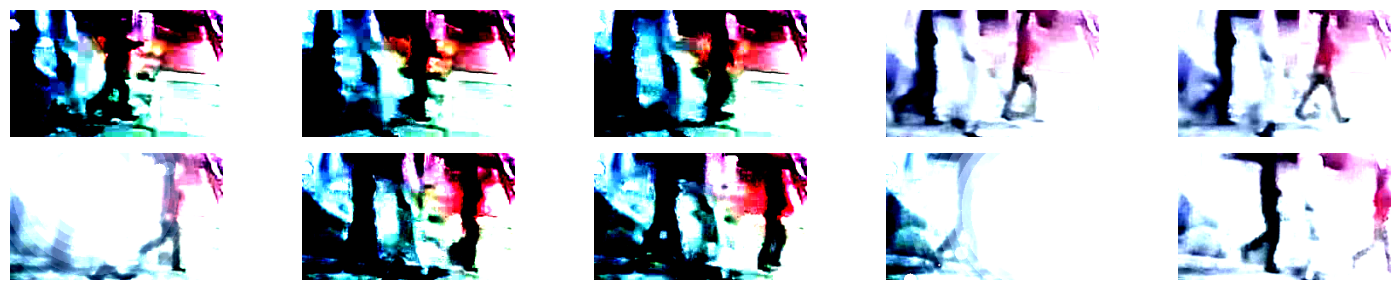

In [12]:
# plot the frames, frames shape: (batch_size, seq_len, h, w, c)
frames = train_dataset[120][0]
temp = frames
temp = temp.permute(0,2,3,1).numpy()
fig, axes = plt.subplots(2, 5, figsize=(15, 3))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(temp[i])
    ax.axis("off")
plt.tight_layout()
plt.show()
# extract edges and plot

# fig, axes = plt.subplots(2, 5, figsize=(15, 3))
# for i, ax in enumerate(axes.flatten()):
#     edge = extract_edges(temp[i])
#     ax.imshow(edge)
#     ax.axis("off")
# plt.tight_layout()
# plt.show()


In [161]:
pt1 = (450, 750)
pt2 = (750, 950)
x,y,w,h = pt1[0],pt1[1],pt2[0]-pt1[0],pt2[1]-pt1[1]
# Load video frames
video_path = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train\1_20241206_165239_L.mp4'
def extract_optical_flow(x, y, w, h, video_path):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    prev_frame = prev_frame[y:y+h,x:x+w]
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    optical_flow_frames = []
# Loop through video frames
    while True:
        ret, next_frame = cap.read()
        if not ret:
            break
        next_frame = next_frame[y:y+h,x:x+w]
        next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, next_gray, None, 
            0.5, 3, 15, 3, 5, 1.2, 0
        )
    # Compute magnitude and angle
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Normalize the magnitude for better visualization
        normalized_magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    
        optical_flow = np.concatenate([magnitude[..., None], angle[..., None]], axis=-1)
        # Save or append the result
        optical_flow_frames.append(optical_flow)
        
    # Update previous frame
        prev_gray = next_gray
    cap.release()
    return optical_flow_frames

optical_flow_frames = extract_optical_flow(x, y, w, h, video_path)

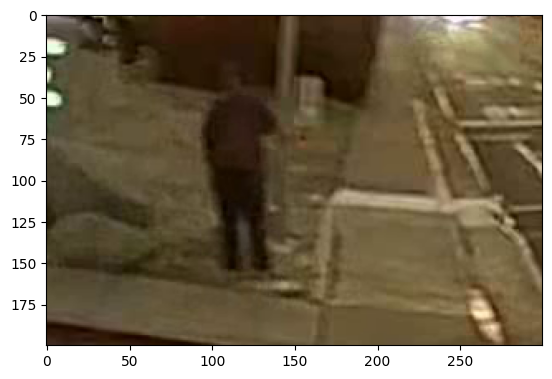

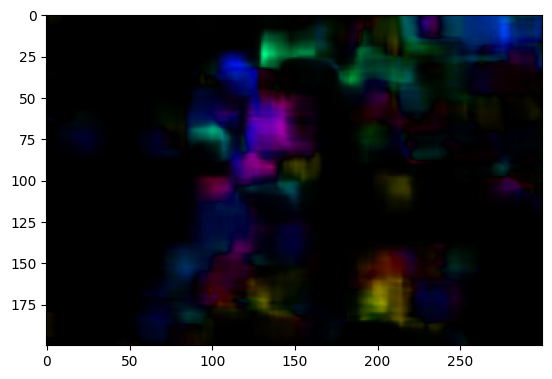

In [158]:
ind = 30
plt.imshow(frames[ind][y:y+h,x:x+w])
plt.show()
plt.imshow(optical_flow_frames[ind])
plt.show()

In [26]:
from Dataset import create_data_loaders

In [27]:
from sklearn.metrics import confusion_matrix
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
train_loader, val_loader = create_data_loaders(train_dir, val_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)
model_path = r"D:\LiDAR_Data\2ndPHB\Video\left_signal_0107\model\best_model.pth"
# model = ResNetLSTMWithAttention().to(device)
model = CNNLSTMAttention().to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))
# calculate the confusion matrix
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs, attention_weights = model(inputs)
            # outputs = model(inputs)
            outputs = torch.flatten(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
confidence_thresholds = np.arange(0.1, 0.9, 0.1)
precision_scores = []
recall_scores = []
F1_scores = []

for threshold in confidence_thresholds:
    y_pred_thresholded = (y_pred > threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred_thresholded)
    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    F1 = 2 * precision * recall / (precision + recall)

    precision_scores.append(precision)
    recall_scores.append(recall)
    F1_scores.append(F1)


Validation: 100%|██████████| 571/571 [00:21<00:00, 26.00it/s]


In [34]:
# dataset statistics for validation set
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
val_dataset = VideoDataset(val_dir, preprocess=preprocessing)
# calculate number of 1 and 0 labels
num_1 = 0
num_0 = 0
for i in range(len(val_dataset)):
    _, label, _ = val_dataset[i]
    if label == 1:
        num_1 += 1
    else:
        num_0 += 1
print(num_1, num_0)


593 548


TP: 580, FP: 5, FN: 13, TN: 543


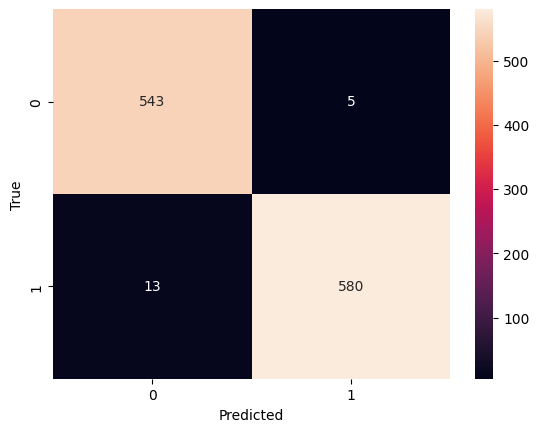

In [33]:
#calcualte confusion matrix at 0.5 threshold
threshold = 0.5
y_pred_thresholded = (y_pred > threshold).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred_thresholded)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
F1 = 2 * precision * recall / (precision + recall)
conf_matrix, precision, recall, F1
TP,FP,FN,TN = conf_matrix[1,1],conf_matrix[0,1],conf_matrix[1,0],conf_matrix[0,0]
print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
# plot graph of confusion matrix 
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

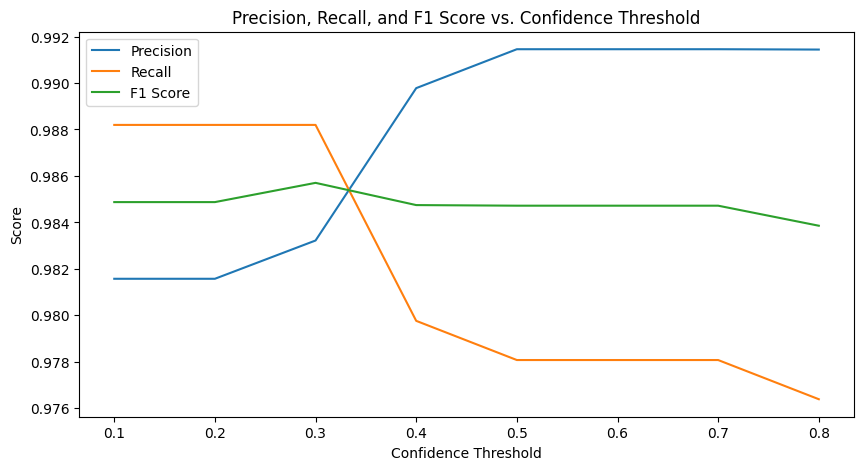

In [29]:
# plot the precision, recall and F1 score curves
plt.figure(figsize=(10, 5))
plt.plot(confidence_thresholds, precision_scores, label="Precision")
plt.plot(confidence_thresholds, recall_scores, label="Recall")
plt.plot(confidence_thresholds, F1_scores, label="F1 Score")
plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision, Recall, and F1 Score vs. Confidence Threshold")
plt.show()

### Inference

In [1]:
from Dataset import VideoDataset,preprocessing,transform_aug
from Model import CNNLSTMAttention
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from Loss import *
from torchvision import models
from MotionAppearanceFusion import TwoStreamModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [2]:
frame_width,frame_height = 250,150
x,y = 450,780
pt1_L = (x, y)
pt2_L = (450+frame_width, 780+frame_height)
x,y = 1450,800
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
ROI_L, ROI_R = [pt1_L, pt2_L], [pt1_R, pt2_R]

In [3]:
# load the video, and screen the video to the region of interest, and extract the optical flow, then make a prediction list
def generate_tensors(model, video_path, pt1, pt2, device):
    # Load video frames
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.array(frames) # (seq_len, h, w, c)
    optical_flow_frames = extract_optical_flow(pt1, pt2, video_path)
    return frames, optical_flow_frames
    

In [8]:
model_path = r"D:\LiDAR_Data\2ndPHB\Video\left_signal_0107\model\best_model.pth" 
model = CNNLSTMAttention().to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()

CNNLSTMAttention(
  (cnn): CNNFeatureExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten(start_dim=1, end_dim=-1)
      (8): Linear(in_features=73408, out_features=256, bias=True)
      (9): ReLU()
    )
  )
  (lstm): LSTM(256, 128, batch_first=True)
  (attention): Attention(
    (attention_weights): Linear(in_features=128, out_features=1, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [9]:
def predict(model, frames, device):
    frames = np.array(frames)
    model.eval()
    with torch.no_grad():
        frames = preprocessing(frames).to(device)
        frames = frames.unsqueeze(0)
        # print(frames.shape,optical_flow_frames.shape)
        outputs, attention_weights = model(frames)
        outputs = torch.flatten(outputs)
        return outputs.cpu().numpy()

In [14]:
pt1 = pt1_L
pt2 = pt2_L
video_path = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo\00_00_192.168.1.108_1_20241207_165500.avi'
# save as mp4 format
save_path  = r'D:\LiDAR_Data\2ndPHB\Video\00_00_192.168.1.108_1_20241207_165500.mp4'
frame_num = 30 # 3 seconds
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)
line_type = 2
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
raw_video_height, raw_video_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (raw_video_width, raw_video_height))
prediction_sequence = [] # store the predicted vectors
ret, cur_frame = cap.read()
cur_raw_frame = cur_frame.copy()
cur_frame = cur_frame[pt1[1]:pt2[1], pt1[0]:pt2[0]]
cur_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
cur_frame_gray = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2GRAY)
frames_rgb = [cur_frame_rgb]
for i in range(1,frame_num):
    ret, frame = cap.read()
    cur_raw_frame = frame.copy()
    if not ret:
        break
    # crop the frame
    frame = frame[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames_rgb.append(frame_rgb)

prediction = predict(model, frames_rgb, device)
# plot prediction value in right bottom corner of the raw frame and write to the video
cv2.putText(cur_raw_frame, str(prediction), (pt2[0], pt2[1]), font, font_scale, font_color, line_type)
out.write(cur_raw_frame)

prediction_sequence.append(prediction)

p_bar = tqdm(total=total_frames - frame_num)
while cap.isOpened():
    ret, cur_frame = cap.read()
    if not ret:
        break
    cur_raw_frame = cur_frame.copy()
    cur_frame = cur_frame[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    cur_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
    frames_rgb.pop(0)
    frames_rgb.append(cur_frame_rgb)
    
    prediction = predict(model, frames_rgb, device)
    cv2.putText(cur_raw_frame, str(prediction[0]), (pt2[0], pt2[1]), font, font_scale, font_color, line_type)
    out.write(cur_raw_frame)

    prediction_sequence.append(prediction)
    p_bar.update(1)
cap.release()
out.release()


100%|██████████| 2969/2969 [02:10<00:00, 17.58it/s]

100%|██████████| 2969/2969 [02:25<00:00, 17.58it/s]

In [124]:
pt1 = (450, 750)
pt2 = (750, 950)
# video_path = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo\00_00_192.168.1.108_1_20241208_075500.avi'
# save_path  = r'D:\LiDAR_Data\2ndPHB\Video\test.mp4'
video_list = os.listdir(r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo')
video_save_folder = r'D:\LiDAR_Data\2ndPHB\Video\L_signal_output'
os.makedirs(video_save_folder, exist_ok=True)
prediction_save_folder = r'D:\LiDAR_Data\2ndPHB\Video\L_signal_prediction'
os.makedirs(prediction_save_folder, exist_ok=True)
for video_name in tqdm(video_list):
    video_path = os.path.join(r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo',video_name)
    # save as mp4 format
    save_path = os.path.join(video_save_folder, video_name.replace('.avi','.mp4'))
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    raw_video_height, raw_video_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (raw_video_width, raw_video_height))
    frame_num = 35 # number of frames to predict
    # do prediction in each 35 frames
    prediction_sequence = [] # store the predicted vectors
    ret, cur_frame = cap.read()
    cur_raw_frame = cur_frame.copy()
    cur_frame = cur_frame[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    cur_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
    cur_frame_gray = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2GRAY)
    frames_rgb = [cur_frame_rgb]
    optical_frames = []
    for i in range(1,frame_num):
        ret, frame = cap.read()
        cur_raw_frame = frame.copy()
        if not ret:
            break
        # crop the frame
        frame = frame[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # compute optical flow
        optical_flow = compute_optical_flow(cur_frame_gray, frame_gray)
        frames_rgb.append(frame_rgb)
        optical_frames.append(optical_flow)
    prediction = predict(model, frames_rgb, optical_frames, device)
    # plot prediction value in right bottom corner of the raw frame and write to the video
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)
    line_type = 2
    cv2.putText(cur_raw_frame, str(prediction), (pt2[0], pt2[1]), font, font_scale, font_color, line_type)
    out.write(cur_raw_frame)

    prediction_sequence.append(prediction)

    # p_bar = tqdm(total=total_frames - frame_num)
    while cap.isOpened():
        ret, cur_frame = cap.read()
        if not ret:
            break
        cur_raw_frame = cur_frame.copy()
        cur_frame = cur_frame[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        cur_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
        cur_frame_gray = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2GRAY)
        frames_rgb.pop(0)
        frames_rgb.append(cur_frame_rgb)
        optical_frames.pop(0)
        optical_flow = compute_optical_flow(cur_frame_gray, frame_gray)
        optical_frames.append(optical_flow)
        
        prediction = predict(model, frames_rgb, optical_frames, device)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (255, 255, 255)
        line_type = 2
        cv2.putText(cur_raw_frame, str(prediction[0]), (pt2[0], pt2[1]), font, font_scale, font_color, line_type)
        out.write(cur_raw_frame)

        prediction_sequence.append(prediction)
        # p_bar.update(1)
    cap.release()
    out.release()
    # save the prediction sequence
    prediction_sequence = np.array(prediction_sequence)
    save_name = os.path.join(prediction_save_folder, video_name.replace('.avi','.npy'))
    np.save(save_name, prediction_sequence)

  3%|▎         | 43/1236 [3:40:49<102:06:34, 308.13s/it]


KeyboardInterrupt: 